In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import georasters as gr
import seaborn as sns
sns.set_theme(style="darkgrid")
import rasterio
from rasterio.plot import show
import copy
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import networkx as nx
from time import time

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
vlm = np.genfromtxt('new_vlm.csv', delimiter=',')
habitat_path = r"../Week 7/habitat_nearest.shp"
habitat = gpd.read_file(habitat_path)

In [3]:
habitat.drop(columns=["col", "index_righ", "OBJECTID", "Id", "HabitatTyp", "HabitatT_1", "HabitatSub", "HabitatS_1",
                             "RuleID", "Shape_Leng", "Shape_Area", "Habitats"], axis=1, inplace=True)
habitat.rename(columns={"Fill": "Habitats"}, inplace=True)

In [4]:
habitat_groups = pd.read_excel('habitat_groups.xlsx', header=None)
habitat_groups.rename(columns={0: "Habitats", 1: "Groups"}, inplace=True)
habitat_groups.set_index("Habitats", inplace=True)
group_dict = habitat_groups.to_dict()['Groups']
habitat["Habitat groups"] = habitat["Habitats"].map(group_dict)

In [6]:
inter_vlm_df = pd.DataFrame(vlm.flatten(), columns=['VLM'])
inter_vlm_df.dropna(inplace=True)
habitat["VLM"] = inter_vlm_df.reset_index().VLM/1000

In [27]:
habitat_new = habitat.drop(columns=['x', 'y', 'Habitats'], axis=1)
habitat_new.rename(columns={'value': 'Elevation', 'Habitat groups': 'Habitats'}, inplace=True)

In [52]:
slr_values = pd.read_excel('slr.xlsx', header=None)
slr = slr_values[[3]]
slr.rename(columns={3: 'SLR'}, inplace=True)
slr_dict = slr.reset_index().set_index('SLR').to_dict()['index']

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [93]:
def visualize_classes(df, col='Intervals'):
    counts = pd.DataFrame(df[col].value_counts())
    if col == 'Intervals':
        counts.sort_index(inplace=True)
    sns.barplot(x=counts.index, y=col, palette="mako", data=counts)
    labels = plt.xticks(rotation=45)

In [102]:
def encode_E(df):
    # Step 1: Create Data Frame:
    elevation_classes = pd.DataFrame()
    elevation_classes['Elevation_Values'] = df.Elevation

    # Step 2: Get Max and Min Values for Elevation
    min_elev = df.Elevation.min()
    max_elev = df.Elevation.max()

    # Step 3: Create Intervals:
    # Intervals
    interval_0 = pd.cut(x=df["Elevation"], bins=[1, 5, 10, max_elev])
    interval_1 = pd.cut(x=df["Elevation"], bins=[min_elev, -10, -1, 0], right=False)
    interval_2 = pd.cut(x=df["Elevation"], bins=[0, 1], include_lowest=True)
    # Encoding
    encoding_0 = pd.cut(x=df["Elevation"], bins=[1, 5, 10, max_elev], labels=[4, 5, 6])
    encoding_1 = pd.cut(x=df["Elevation"], bins=[min_elev, -10, -1, 0], right=False, labels=[0, 1, 2])
    encoding_2 = pd.cut(x=df["Elevation"], bins=[0, 1], include_lowest=True, labels=[3])

    # Step 4: Add intervals to dataframe:
    elevation_classes['Intervals_0'] = interval_0
    elevation_classes['Intervals_1'] = interval_1
    elevation_classes['Intervals_2'] = interval_2
    elevation_classes['Intervals'] = ''

    elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
    elevation_classes.loc[ ((elevation_classes.Intervals_0.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
    elevation_classes.loc[ ((elevation_classes.Intervals_1.isnull()) & (elevation_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

    # Step 5: Add class encoding
    elevation_classes['Encoding_0'] = encoding_0
    elevation_classes['Encoding_1'] = encoding_1
    elevation_classes['Encoding_2'] = encoding_2
    elevation_classes['Encoding'] = ''

    elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
    elevation_classes.loc[ ((elevation_classes.Encoding_0.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
    elevation_classes.loc[ ((elevation_classes.Encoding_1.isnull()) & (elevation_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

    elevation_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                           axis='columns', inplace=True)
    
    # Uncomment to see which number encodes which interval
    # for i in range(7):
    #     print(f"Bin #{i}, interval: {elevation_classes[elevation_classes.Encoding == i].Intervals.iloc[i]}")
        
    # Uncomment to visualize classes
    # visualize_classes(elevation_classes)
    
    return elevation_classes

In [90]:
def encode_VLM(df):
    vlm_classes = pd.DataFrame()
    vlm_classes['VLM_Values'] = df.VLM

    # Intervals
    vlm_intervals = pd.qcut(df.VLM, q=3)

    # Encoding
    vlm_encoding = pd.qcut(df.VLM, q=3, labels=[0, 1, 2])

    vlm_classes['Intervals'] = vlm_intervals
    vlm_classes['Encoding'] = vlm_encoding
    
    # Uncomment to see which number encodes which interval
    # for i in range(3):
    #     print(f"Bin #{i}, interval: {vlm_classes[vlm_classes.Encoding == i].Intervals.iloc[i]}")
    
    # Uncomment to visualize classes
    # visualize_classes(vlm_classes)
    
    return vlm_classes

In [109]:
def encode_habitat(df):
    h_groups = ['Subaqueous', 'Rocky', 'Marsh/Salt Flats', 'Sandy', 'Forest', 'Developed']
    h_encoding = [0, 1, 2, 3, 4, 5]
    h_df = pd.DataFrame(list(zip(h_groups, h_encoding)), columns=['Habitat', 'Encoding'])
    h_df.set_index('Habitat', inplace=True)
    h_dict = h_df.to_dict()['Encoding']
    
    habitat_classes = pd.DataFrame()
    habitat_classes['Values'] = df['Habitats']
    habitat_classes['Encoding'] = df['Habitats'].map(h_dict)
    
    # Uncomment to see which number encodes which habitat group
    # for i in range(6):
    #     print(f"Bin #{i}, habitat: {habitat_classes[habitat_classes.Encoding == i].Values.iloc[i]}")
    
    # Uncomment to visualize classes
    # visualize_classes(habitat_classes, col='Values')
    
    return habitat_classes

In [101]:
def encode_AE(df):
    # Step 1: Create Data Frame:
    ae_classes = pd.DataFrame()
    ae_classes['Values'] = df.AE

    # Step 2: Get Max and Min Values for Elevation
    min_AE = df.AE.min()
    max_AE = df.AE.max()

    # Step 3: Create Intervals:
    # Intervals
    interval_0 = pd.cut(x=df.AE, bins=[1, 5, 10, max_AE])
    interval_1 = pd.cut(x=df.AE, bins=[min_AE, -12, -1, 0], right=False)
    interval_2 = pd.cut(x=df.AE, bins=[0, 1], include_lowest=True)
    # Encoding
    encoding_0 = pd.cut(x=df.AE, bins=[1, 5, 10, max_AE], labels=[4, 5, 6])
    encoding_1 = pd.cut(x=df.AE, bins=[min_AE, -12, -1, 0], right=False, labels=[0, 1, 2])
    encoding_2 = pd.cut(x=df.AE, bins=[0, 1], include_lowest=True, labels=[3])

    # Step 4: Add intervals to dataframe:
    ae_classes['Intervals_0'] = interval_0
    ae_classes['Intervals_1'] = interval_1
    ae_classes['Intervals_2'] = interval_2
    ae_classes['Intervals'] = ''

    ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_1.isnull())), 'Intervals'] = interval_2
    ae_classes.loc[ ((ae_classes.Intervals_0.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_1
    ae_classes.loc[ ((ae_classes.Intervals_1.isnull()) & (ae_classes.Intervals_2.isnull())), 'Intervals'] = interval_0

    # Step 5: Add class encoding
    ae_classes['Encoding_0'] = encoding_0
    ae_classes['Encoding_1'] = encoding_1
    ae_classes['Encoding_2'] = encoding_2
    ae_classes['Encoding'] = ''

    ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_1.isnull())), 'Encoding'] = encoding_2
    ae_classes.loc[ ((ae_classes.Encoding_0.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_1
    ae_classes.loc[ ((ae_classes.Encoding_1.isnull()) & (ae_classes.Encoding_2.isnull())), 'Encoding'] = encoding_0

    ae_classes.drop(['Intervals_2', 'Intervals_1', 'Intervals_0', 'Encoding_2', 'Encoding_1', 'Encoding_0'],
                    axis='columns', inplace=True)
    
    # Uncomment to see which number encodes which interval
    # for i in range(7):
    #     print(f"Bin #{i}, interval: {ae_classes[ae_classes.Encoding == i].Intervals.iloc[i]}")
        
    # Uncomment to visualize classes
    # visualize_classes(ae_classes)
    
    return ae_classes

In [133]:
def get_encoded_df(df, slr):
    encoded = pd.DataFrame()
    elevation_classes = encode_E(df)
    habitat_classes = encode_habitat(df)
    vlm_classes = encode_VLM(df)
    ae_classes = encode_AE(df)
    
    encoded['SLR'] = ''
    encoded['E'] = elevation_classes.Encoding
    encoded['VLM'] = vlm_classes.Encoding
    encoded['AE'] = ae_classes.Encoding
    encoded['LC'] = habitat_classes.Encoding
    encoded.SLR = slr
    
    return encoded

In [145]:
scenarios = []
scenarios_encoded = []
t = time()
for i in range(7):
    scenario = habitat_new.drop(columns=['geometry'], axis=1)
    scenario['SLR'] = slr.iloc[i].SLR
    scenario['AE'] = scenario.Elevation - scenario.SLR + scenario.VLM
    scenarios.append(scenario)
    scenarios_encoded.append(get_encoded_df(scenario, i))
print("Creating and encoding 7 scenarios: %.2fs" % (time() - t))

Creating and encoding 7 scenarios: 47.73s


In [152]:
cpd_cr = pd.read_csv('cpd_cr_new.csv', header=None, index_col=0)

In [155]:
cpd_cr.columns = pd.MultiIndex.from_arrays([cpd_cr.iloc[0], cpd_cr.iloc[1]])
cpd_cr = cpd_cr.iloc[2:].reset_index(drop=True)
cpd_cr

AE 0.0                         1.0                   ... 5.0                  \
LC 0.0 1.0   2.0  3.0 4.0 5.0  0.0   1.0   2.0  3.0  ... 2.0 3.0   4.0   5.0   
0    0   1  0.95  0.8   1   1  0.1  0.95  0.75  0.6  ...   0   0  0.05  0.05   
1    1   0  0.05  0.2   0   0  0.9  0.05  0.25  0.4  ...   1   1  0.95  0.95   

AE 6.0                      
LC 0.0 1.0 2.0 3.0 4.0 5.0  
0    1   0   0   0   0   0  
1    0   1   1   1   1   1  

[2 rows x 42 columns]

In [169]:
def look_up_CR(df):
    '''
    CR column: 1 if P(dynamic >= 0.5), 0 otherwise
    '''
    cr_0 = df.apply(lambda row: cpd_cr.xs(row.AE, level='AE', axis=1)[row.LC].iloc[0], axis=1)
    cr_1 = 1 - cr_0
    cr = df.apply(lambda row: 1 if cpd_cr.xs(row.AE, level='AE', axis=1)[row.LC].iloc[0] <= 0.5 else 0, axis=1)
    lookup = pd.DataFrame(list(zip(cr_0, cr_1, cr)), columns=['CR_0', 'CR_1', 'CR'])
    return lookup

## Trying first scenario
Not doing all scenarios at once yet, since looking up the CR for one scenario takes about 6 minutes.

In [172]:
s0 = scenarios_encoded[0]
t = time()
cr0 = look_up_CR(s0)
print("Looking up CR: %.2fs" % (time() - t))

Looking up CR: 705.53s


In [174]:
s0['CR'] = cr0.CR

In [185]:
s0_test = s0.drop(columns=['CR'], axis=1)

In [179]:
model = BayesianModel([('SLR', 'AE'),
                       ('VLM', 'AE'),
                       ('E', 'AE'),
                       ('E', 'LC'),
                       ('LC', 'CR'),
                       ('AE', 'CR')])

In [180]:
model.fit(s0, estimator=BayesianEstimator, prior_type="BDeu")

### Evaluating: binary predictions

In [186]:
from sklearn.metrics import accuracy_score

In [189]:
binary_preds = model.predict(s0_test)

100%|██████████| 151/151 [00:00<00:00, 468.52it/s]


In [190]:
accuracy_score(s0['CR'], binary_preds)

1.0

### Evaluating: probability predictions

In [191]:
from sklearn.metrics import mean_absolute_error

In [205]:
t = time()
n = 5000
prob_preds = model.predict_probability(s0_test[:n])
print(f"Making predictions for {n} points: %.2fs" % (time() - t))

Making predictions for 5000 points: 86.96s


In [208]:
mean_absolute_error(cr0['CR_1'][:n], prob_preds['CR_1'])

0.2229590960263953

In [210]:
mean_absolute_error(cr0['CR_0'][:n], prob_preds['CR_0'])

0.22295909602639521

### Smaller model

In [213]:
model_small = BayesianModel([('LC', 'CR'), ('AE', 'CR')])

In [217]:
s0_small = s0[['AE', 'LC', 'CR']]
s0_test_small = s0[['AE', 'LC']]

In [216]:
model_small.fit(s0_small, estimator=BayesianEstimator, prior_type="BDeu")

In [218]:
binary_preds_small = model_small.predict(s0_test_small)

100%|██████████| 42/42 [00:04<00:00,  8.84it/s]


In [219]:
accuracy_score(s0['CR'], binary_preds_small)

1.0

In [220]:
t = time()
n = 1000
prob_preds_small = model_small.predict_probability(s0_test_small[:n])
print(f"Making predictions for {n} points: %.2fs" % (time() - t))

Making predictions for 1000 points: 3.91s


In [221]:
mean_absolute_error(cr0['CR_1'][:n], prob_preds_small['CR_1'])

0.2122491350919264

## Looking up CR for all scenarios

In [226]:
CRs = []
t0 = time()
for i in range(7):
    t = time()
    cr = look_up_CR(scenarios_encoded[i])
    CRs.append(cr)
    print(f"Looking up CR for scenario #{i}: %.2fs" % (time() - t))
print("Looking up CR for all scenarios: %.2fs" % (time() - t0))

Looking up CR for scenario #0: 710.26s
Looking up CR for scenario #1: 689.89s
Looking up CR for scenario #2: 702.87s
Looking up CR for scenario #3: 683.58s
Looking up CR for scenario #4: 691.71s
Looking up CR for scenario #5: 673.81s
Looking up CR for scenario #6: 667.34s
Looking up CR for all scenarios: 4819.47s


In [230]:
for i in range(7):
    CRs[i].to_csv(f"CR_lookup_{i}.csv")

## Selecting data for testing

In [279]:
scenarios_encoded[0][scenarios_encoded[0].E.isin([2, 3, 4])]

,SLR,E,VLM,AE,LC,CR
0,0,3,2,3,5,1
1,0,3,2,2,5,0
2,0,3,2,3,5,1
3,0,3,2,3,5,1
4,0,4,2,4,5,1
...,...,...,...,...,...,...
1788783,0,4,2,4,3,1
1788784,0,4,2,4,3,1
1788789,0,4,2,4,3,1
1788822,0,4,2,4,2,1


In [271]:
pd.DataFrame(e_classes.Intervals.value_counts()).sort_index()

,Intervals
"[-89.0, -10.0)",2895
"[-10.0, -1.0)",76021
"[-1.0, 0.0)",77165
"(-0.001, 1.0]",389632
"(1.0, 5.0]",603235
"(5.0, 10.0]",231449
"(10.0, 83.0]",409264


In [288]:
short_habitat = habitat_new[(habitat_new.Elevation >= -1) & (habitat_new.Elevation <= 5)]

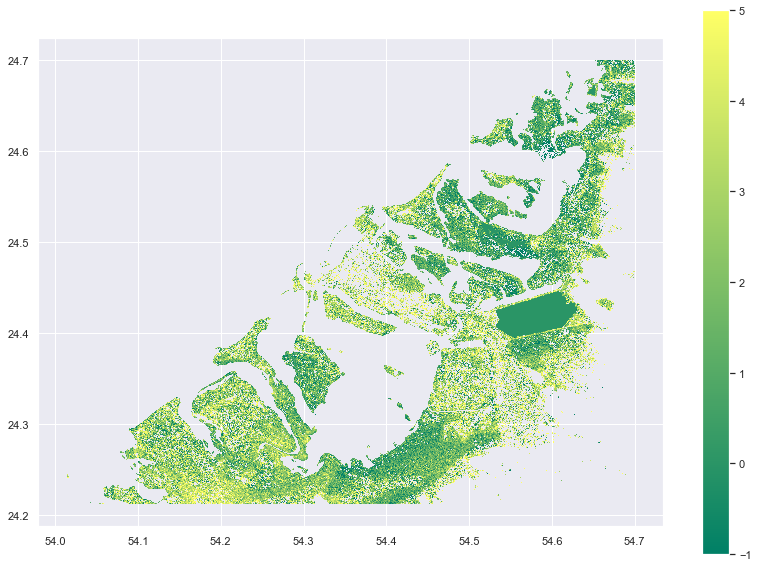

In [289]:
f, ax = plt.subplots(1, 1, figsize=(14, 10))
ax = short_habitat.plot(column='Elevation', ax=ax, legend=True, cmap='summer', edgecolor="face", linewidth=0.)
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.25, 1))
plt.show()

In [291]:
short_habitat.Habitats.value_counts()

Developed           349027
Sandy               334360
Marsh/Salt Flats    228818
Forest              104882
Subaqueous           43779
Rocky                 9166
Name: Habitats, dtype: int64

## Inspecting probability predictions

In [333]:
val = prob_preds.CR_1.value_counts().index[0]
same_prob = prob_preds[prob_preds.CR_1 == val]
same_prob

,CR_0,CR_1
63,0.999999,0.000001
64,0.999999,0.000001
83,0.999999,0.000001
84,0.999999,0.000001
85,0.999999,0.000001
...,...,...
4995,0.999999,0.000001
4996,0.999999,0.000001
4997,0.999999,0.000001
4998,0.999999,0.000001


In [334]:
same_encoded = scenarios_encoded[0].loc[same_prob.index]
same_encoded

,SLR,E,VLM,AE,LC,CR
63,0,1,2,1,3,0
64,0,1,2,1,3,0
83,0,1,2,1,3,0
84,0,1,2,1,3,0
85,0,1,2,1,3,0
...,...,...,...,...,...,...
4995,0,2,2,1,3,0
4996,0,1,2,1,3,0
4997,0,1,2,1,3,0
4998,0,2,2,1,3,0


In [335]:
print(same_encoded.AE.value_counts())
print(same_encoded.LC.value_counts())

1    1173
Name: AE, dtype: int64
3    1173
Name: LC, dtype: int64


## Trying caching the probability predictions

In [387]:
def predict_prob_caching(model, test):
    cache_dict = {}
    prob_list = []
    for _, data_point in test.iterrows():
        keys = (data_point.AE, data_point.LC)
        if keys not in cache_dict:
            pred_df = model.predict_probability(pd.DataFrame([data_point]))
            pred_CR1 = pred_df.iloc[0].CR_1
            cache_dict[keys] = pred_CR1
        prob_list.append(cache_dict[keys])
    return pd.DataFrame(prob_list, columns=['CR_1'])

In [401]:
t = time()
n = 5000
prob_preds = model.predict_probability(s0_test[5000:5000+n])
print(f"Making predictions for {n} points: %.2fs" % (time() - t))

Making predictions for 5000 points: 85.68s


In [400]:
t = time()
n = 5000
prob_preds_cache = predict_prob_caching(model, s0_test[5000:5000+n])
print(f"Making predictions (with caching) for {n} points: %.2fs" % (time() - t))

Making predictions (with caching) for 5000 points: 0.69s


In [410]:
np.unique(prob_preds.CR_1.values == prob_preds_cache.CR_1.values)

array([ True])

In [419]:
t = time()
n = habitat_new.shape[0]
prob_preds_cache = predict_prob_caching(model, s0_test[:n])
print(f"Making predictions (with caching) for {n} points: %.2fs" % (time() - t))

Making predictions (with caching) for 1789661 points: 74.86s


In [420]:
mean_absolute_error(cr0['CR_1'], prob_preds_cache['CR_1'])

0.1321089202173002